# Probabilistic Machine Learning
#### University of Tübingen, Summer Term 2021
## Exercise Sheet 09
&copy; 2021 Prof. Dr. Philipp Hennig, Marius Hobbhahn, Agustinus Kristiadi & Nicolas Krämer

This sheet is **due on Tuesday, 29 June 2021, at 10:00 sharp.**

---

# Exercise #9: Time Series Analysis with Categorical Data 


<!-- ![](./figures/graphicalmodel.png) -->


On this exercise sheet, we are going to practice on doing GLM inference in a graphical model using Gaussian processes, the Laplace Bridge and categorical data.
We are using an artificial data set today.

The structure is the following:

1. **Time series data:** The usual loading and processing of data.
2. **Laplace bridge:** Implementation of the Laplace bridge and basic checkups. (Definition and explanation below.)
3. **Combining GPs with a graphical model:** How do we use GPs in a GM.


In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [150]:
sns.set()
%config InlineBackend.figure_formats = 'svg', 'pdf', 'png'

# Part I: Time series data

On this sheet we are working with time series categorical data. 
You may think of it as the results of a political election.
There are $M=6$ parties and the election has taken place every year for the past $N=100$ years (we are at year 100 now and the first year was year 0).
Each of the 6 parties has received a number of votes.

Below you find a snippet that loads the `timeseries.csv` data set into a `pd.DataFrame`.


In [151]:
data = pd.read_csv('timeseries.csv', index_col=0)

n_timepts = data.values.shape[0]
n_categs = data.values.shape[1]

### Task: 

Plot the cumulative results of each party over time, for instance like the following:

This kind of plot will be interesting below as it is a simple way to visualise time-evolution of discrete probability distributions. *Hint:* `pd.DataFrame` objects have a built-in method `.plot.area()`. 

<AxesSubplot:>

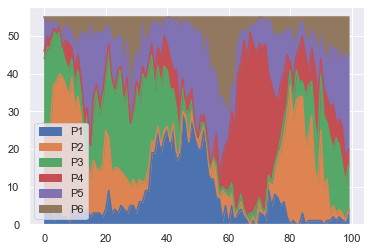

In [152]:
# Plot
data.plot.area()

Now that we have a first idea of the data set, we can start working.


We split the data into a training set and a test set.

In [153]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.index, data.values, test_size=0.3, shuffle=True
)

# Part II: Getting comfortable with the Dirichlet

For every year $n$ there is a vector of counts of votes $c_n$. These counts $c_n$ represent a Categorical distribution. The observed counts $c_n$ are one possible election result, but we are interested in the generative distribution of said election. The Dirichlet is a distribution over probability vectors---the parameters of a Categorical distribution---and hence a good choice for election outcomes. 

### Task: 

Assume we have a Dirichlet prior distribution $p(\pi_n) = \mathcal{D}(\pi_n; \alpha_n)$ for election year $n$ and the categorical election results $c_n$ with $p(c_n \vert \pi_n)$. The posterior distribution $p(\pi_n \vert c_n)$ is again a Dirichlet. What is the update rule for this setting? Write down the solution. Derivation is not required.

$$p(\pi_n\,\mid\,c_n) \propto p(c_n\,\mid\,\pi_n)\,p(\pi_n\,\mid\,\alpha_n)$$

$p(\pi_n\,\mid\,c_n)$ is again Dirichlet distributed, so

$$p(\pi_n\,\mid\,c_n) = \text{Dir}(\pi_n\,\mid\,\alpha_n')$$

with

$$(\alpha_n')_k = (\alpha_n)_k + (c_n)_k$$

### Task: 

We now want to look at one specific election in more detail. Choose a year $i$ and compute the posterior parameters $\alpha_i'$ given the election counts $c_i$ and prior $\alpha_i = (1, ..., 1)$. We are now interested in the marginal distribution for every party instead of the joint for entire election. Plot the marginal distributions for every party. **Hint:** The marginals of the Dirichlet have a nice form and no samples are required. 

In [154]:
# Dirichlet marginal math
from scipy.stats import beta

year = 50    # = i
alpha_prior = np.ones(data.shape[1])
alpha = alpha_prior + data.iloc[year]
beta_ = alpha.sum() - alpha

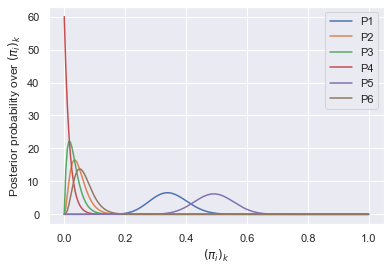

In [155]:
# Dirichlet marginal plot

x = np.linspace(0, 1, 200)
fig, ax = plt.subplots()
for i, n in enumerate(data.columns):
    ax.plot(x, beta.pdf(x, alpha[i], beta_[i]), label=n)
ax.set_xlabel('$(\pi_i)_k$')
ax.set_ylabel('Posterior probability over $(\pi_i)_k$')
plt.legend()
plt.show()

# Part III: The Laplace Bridge

We are now able to create Dirichlet distributions for every timestep. But we still don't know how to connect them to make use of the time-component of our election data. This is what we will try to do here, by using a local form of Laplace approximations that we could call a [Laplace Bridge](https://arxiv.org/abs/2003.01227), which was introduced in Exercise 2. Let's start by understanding what the Laplace Bridge is and then combine it with Gaussian Processes. 

The Laplace Bridge is a way to map a Dirichlet random variable $\pi \sim \text{Dir}(\alpha)$ to a Gaussian random variable $y \sim \mathcal{N}(\mu, \Sigma)$ through
\begin{align*}
\mu_m &= \log \alpha_m - \frac{1}{M}\sum_{\ell=1}^M \log \alpha_\ell. \\
\Sigma_{mm} &=  \frac{1}{\alpha_m} \left(1 - \frac{2}{M} \right)
    + \frac{1}{M^2}\sum_{\ell=1}^M \frac{1}{\alpha_\ell}.
\end{align*}
Its inverse is given by the map 
\begin{align}
 \alpha_m = \frac{1}{\Sigma_{mm}} \left( 1 - \frac{2}{M} + \frac{e^{\mu_m}}{M^2} \sum_{\ell=1}^M e^{-\mu_\ell}\right).
\end{align}
Derivation of both of these formulas was part of the theoretical exercise.


### Task:

Implement a function that maps a Dirichlet concentration hyperparameter $\alpha \in \mathbb{R}_+^M$ to a Gaussian random variable $\mu \in \mathbb{R}^M$, $\Sigma \in \mathbb{R}^{M \times M}$ for number of categories $M$. Implement another function that does the reverse.

In [156]:
# maps from Dir to Gaussian and back

def dir2gauss(alpha):
    M = len(alpha)
    mu = np.log(alpha) - np.log(alpha).sum()/M
    sigma = (1 - 2/M)/alpha + (np.sum(1 / alpha) / M**2)
    return mu, sigma*np.eye(M)

def gauss2dir(mu, sigma):
    M = len(mu)
    alpha = (1 - 2/M + (np.exp(mu) * np.sum(np.exp(-mu)) / M**2)) / np.diag(sigma)
    return alpha

The Laplace Bridge is an injective function from the space of Dirichlet concentration parameters $\alpha$ to the space of Gaussians, parameterised by mean $\mu$ and covariance $\Sigma$.

To validate our implementation, below there is a test that checks that wherever the inverse of the Laplace Bridge is well-defined, we have implemented it correctly. The function `test_dir2dir` checks that the map $\alpha \mapsto (\mu, \Sigma) \mapsto \alpha$ is the identity.

In [157]:
def test_dir2dir(n_categs=5):
    '''
    Dirichlet to Gaussian to Dirichlet should be identity.
    '''
    alpha_ = np.random.rand(n_categs)
    assert np.linalg.norm(gauss2dir(*dir2gauss(alpha_))- alpha_) < 1e-12

In [158]:
# Execution of tests
testnums = np.random.randint(2, 50, 5)

for num in testnums:
    test_dir2dir(num)
    
print('All clear!')

All clear!


In the theoretical exercise you have shown that the Laplace bridge relies on a change of coordinates: Dirichlet realisations $\pi_r$ ($r$ for 'realisation') are written as the softmax of Gaussian realisations $\sigma(y_r)$, where $y_r$ is a realisation of a Gaussian  $y$.

In [159]:
def softmax(arr):
    assert arr.ndim == 1
    return np.exp(arr) / np.exp(arr).sum()

The Laplace bridge is in place and working now. We are able to pass messages between Dirichlets and Gaussians and through conjugacy, between Categoricals, Dirichlets and Gaussians.

# Part IV: Combining GPs with a graphical model


Let $f = (f_1, ..., f_M)$, $f_m \sim \text{GP}(0, k)$ be $M$ independent Gaussian processes, each with covariance kernel $k=k(t, t')$.
Denote the time-points of the data by $t_1, ..., t_N$.

Consider the following graphical model. Let $y \in \mathbb{R}^M$ be a Gaussian random variable that stems from evaluating each of the Gaussian processes $f_1, ..., f_M$ at time $t \in \{t_1, ..., t_N\}$, let $\pi \in \mathbb{R}_+^M$ be a Dirichlet r.v. and $c \in \mathbb{N}^M$ a Categorical random variable.

The orange rectangle denotes the softmax transformation and the associated Laplace bridge. The blue rectangle denotes the Dirichlet-Categorical conjugacy. The random variable $c$ is observed at each time $t_1, ..., t_N$ (and as an observed r.v., marked with double circles).


Assume that the $M$ GPs $f=(f_1, ..., f_M)$ are independent and each has the same covariance kernel $k$.
Those GPs shall encode the time-correlation between observation (as features). Eventually, we will do GP regression in the $y$ space and to this end, we need two ingredients: a prior and a likelihood.


### Prior distribution

As always, we choose a prior by choosing a covariance kernel $k$. Below you find an implementation of a square exponential kernel. You can play around with the hyperparameters $\sigma^2$ and the length-scale but the provided ones should yield reasonable results already. 

In [160]:
def kernel_func(t, s, output_scale=0.1, length_scale=3):
    '''
    Square exponential kernel for a SINGLE Gaussian process.
    '''
    return output_scale*np.exp(-np.abs(t-s)**2/(2*length_scale**2))


def kernel_mat(x1, x2):
    '''
    Kernel matrix out of a kernel function for a SINGLE Gaussian process.
    x1, x2 are both vectors
    '''
    return np.array([[kernel_func(t, s) for s in x2] for t in x1])

## Constructing a Likelihood

At each timepoint $n$ we create a Dirichlet distribution $p(y_n) = \mathcal{D}(y_n; c_n)$ which can be seen as a cavity distribution. Since a party can theoretically have zero votes in an election but the Dirichlet distribution is undefined for $\alpha$-values of zero, we have to think about this corner case. 

### Task: 

Think of at least two different ways to solve the problem when $c_{nm} = 0$. What are the pros and cons of the approaches?

One approach would be to add 1 to every count. This has the benefit that the differences between counts remain the same. However, the proportions do change.

Another approach would be to add 1 only if $c_{nm} = 0$. This has the benefit that nothing changes if there are no zeros. However, if there are zeros, the differences as well as the proportions of counts change.

Now we want to create a GP with the Dirichlet cavity distributions. Assume we have a Gaussian process prior and *for each* data point $t_n$, we evaluate the prior Gaussian distribution $f(t_n) \sim \mathcal{N}(0, I_M \otimes k(t_n, t_n))$ 

This prior cannot be updated with our Dirichlet distribution as our likelihood has to have a Gaussian form. However, with the Laplace Bridge, we can create a very close Gaussian approximation to the Dirichlet distribution and then update the latent GP prior with it. 

$$
\mathcal{N}(m_n^c, S_n^c) = \text{LB}(\mathcal{D}(c_n))
$$

### Task: 

Train each Gaussian process $f_1, ..., f_M$ on data with likelihood $m_n^c, S_n^c$. Write a function that evalutes the posterior mean at arbitrary point $t$ (which could be contained in either, training or test set). 

**Hint:** In order to be able to train once and evaluate many times, it might be advantageous to compute the natural parameters of the posterior distribution $p(f | c)$, say $\tilde P$ and $\tilde M$ such that the function that evaluates the distribution $f(t)$ at new time point $t$ returns mean and covariance. Furthermore, you don't have to fine-tune any noise parameters for the kernel, as it is already given by the covariance from the Laplace Bridge $\tilde{P} = (K + \Sigma)^{-1}$

$$
\mu(t) = k_M(t, \mathcal{T}) \,\tilde M, \quad \Sigma(t, s) = k_M(t, s) - k_M(t, \mathcal{T})\, \tilde P \,k_M(\mathcal{T}, s) 
$$

for training set $\mathcal{T} = \{t_1, ..., t_N\}$ and covariance $k_M(t, s) = I_M \otimes k(t, s)$.


In [161]:
from scipy.linalg import solve

In [162]:
# train the GP
M = data.shape[1]
T = X_train
m = np.empty((len(X_train), M))
S = np.empty((len(X_train), M, M))
for i, c in enumerate(y_train):
    m[i], S[i] = dir2gauss(np.ones(M) + c)

def posterior_dist(t):
    t = np.asarray(t)
    m_post = np.zeros((M, len(t)))
    S_post = np.zeros((M, len(t), len(t)))
    for c in range(M):
        m_post[c] = kernel_mat(t, T) @ solve(kernel_mat(T, T) + np.diag(S[:, c, c]), m[:, c], assume_a='pos')
        S_post[c] = (kernel_mat(t, t)
            - kernel_mat(t, T)@solve(kernel_mat(T, T) + np.diag(S[:, c, c]), kernel_mat(T, t), assume_a='pos'))
    return m_post, S_post

We use the posterior mean as a point estimate but feel free to use whatever you like instead.

### Task:

Write a function that extracts a point estimate from the GP posterior distribution and turns it into a point estimate for the posterior Dirichlet distribution. **Hint:** Softmax.


In [163]:
def estimate(tset):
    mean, cov = posterior_dist(tset)
    point_estimate = mean.reshape((n_categs, -1)).T
    return np.array([softmax(m) for m in point_estimate])

### Task:

Compute this point estimate for the training set and compare it to the actual training inputs, by e.g. visualising the results.

They should be recovered well.

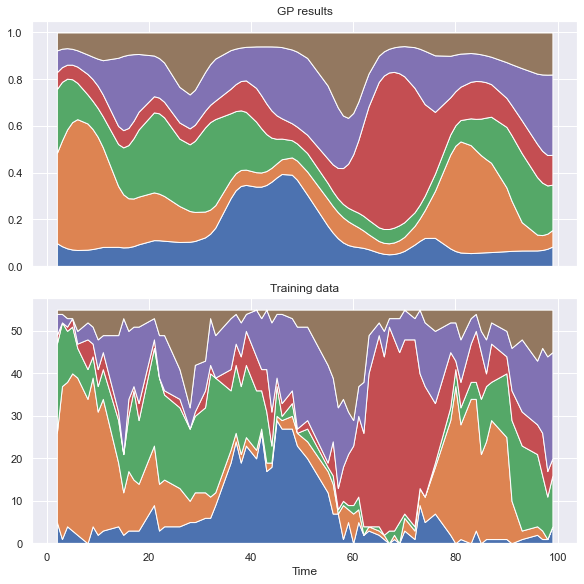

In [164]:
# Compute estimate for training points and plot it
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8), constrained_layout=True)
ax[0].set_title("GP results")
ax[1].set_title("Training data")
ax[1].set_xlabel("Time")
ax[0].stackplot(sorted(T), estimate(sorted(T)).T)
ax[1].stackplot(sorted(T), data.iloc[sorted(T)].values.T)

The trends from the input data can clearly be identified in the GP results. The GP results are much smoother however.

## Test set

### Task:

Compute this point estimate for the test set and compare it to the actual training inputs, by e.g. visualising the results.

How good is the prediction?

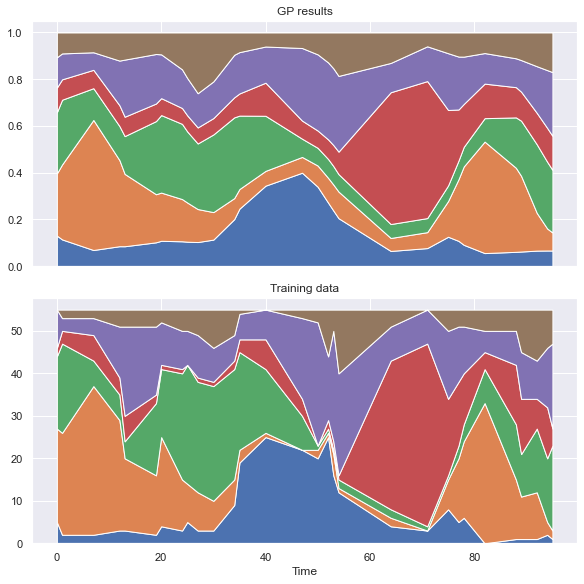

In [165]:
# Compute estimate for test set and plot it
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8), constrained_layout=True)
ax[0].set_title("GP results")
ax[1].set_title("Training data")
ax[1].set_xlabel("Time")
ax[0].stackplot(sorted(X_test), estimate(sorted(X_test)).T)
ax[1].stackplot(sorted(X_test), data.iloc[sorted(X_test)].values.T)

Here, some differences can be seen, some trends not captured by the model; nevertheless most trends are visible.

### Task: 

So far we have not looked at the uncertainty of the predictions, even though that is one of the key advantages of GPs.  Draw multiple samples (at least 10) from the GP and plot them over the entire period of all 100 elections. Where do you see the largest uncertainties? What influences the uncertainty you see in the samples?

In [166]:
from scipy.stats import multivariate_normal

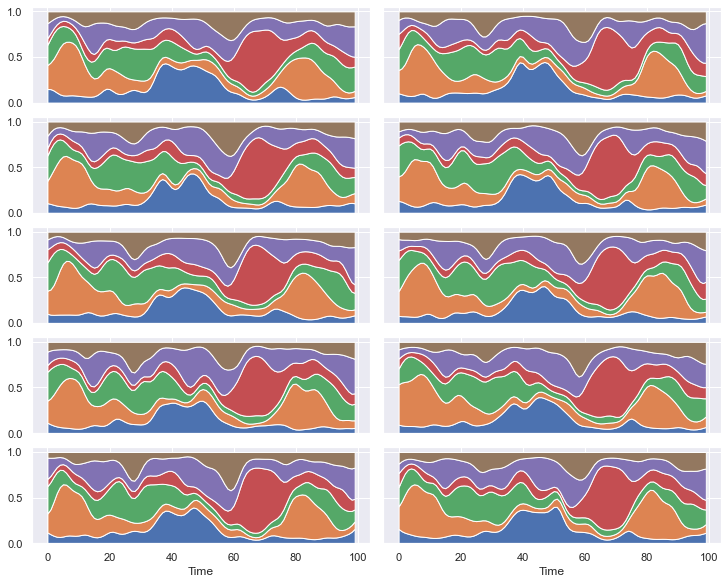

In [167]:
# Draw GP samples and plot them

def sample(t, n):
    mean, cov = posterior_dist(t)
    samples = np.empty((n, M, len(t)))
    for c in range(M):
        rv = multivariate_normal(mean[c], cov[c] + 1e-10*np.eye(len(t)))
        samples[:, c, :] = rv.rvs(n)
    return np.exp(samples) / np.exp(samples).sum(1, keepdims=True)

samples = sample(data.index, 10)

fig, ax = plt.subplots(5, 2, sharey=True, sharex=True, constrained_layout=True, figsize=(10, 8))
for i, a in enumerate(ax.ravel()):
    a.stackplot(data.index, samples[i])
    if i > 7: a.set_xlabel('Time')

The largest uncertainties are where the Laplace bridge has the largest variance, i.e. where the alpha parameter is particularly small.

### Task: 

In the test-train split right in the beginning of the notebook we set `shuffle=True`. Think about what would happen if `shuffle=False` and then see if your expectation is confirmed by rerunning the entire notebook with `shuffle=False`. 

With `shuffle=False` the problem becomes a time series prediction problem. Because we have no information about the outcomes of future elections, performance will necessarily decrease. The mean function of the GPs will return to 0, such that after some time (probably not that long, `length_scale=3`) all parties will have the same predicted probability.

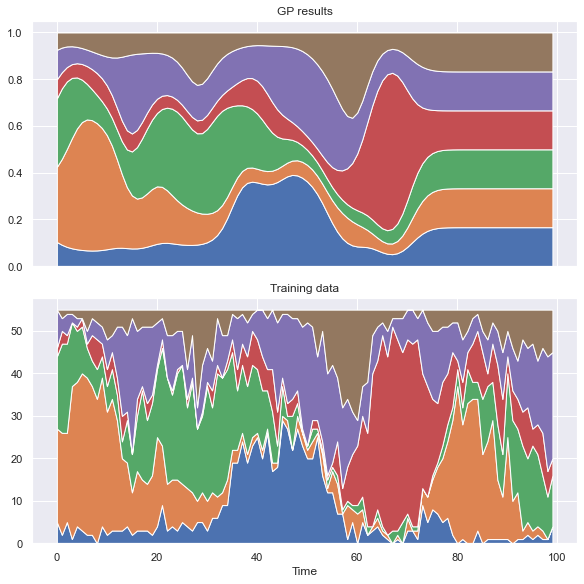

In [148]:
# Result:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8), constrained_layout=True)
ax[0].set_title("GP results")
ax[1].set_title("Training data")
ax[1].set_xlabel("Time")
ax[0].stackplot(data.index, estimate(data.index).T)
ax[1].stackplot(data.index, data.values.T)

(what was predicted did happen.)